
Threshold: 2.0
Accuracy: 0.72, Precision: 0.63, Recall: 0.97
Anomalies Detected: 5428

Threshold: 2.05
Accuracy: 0.72, Precision: 0.63, Recall: 0.97
Anomalies Detected: 5428

Threshold: 2.0999999999999996
Accuracy: 0.72, Precision: 0.63, Recall: 0.97
Anomalies Detected: 5425

Threshold: 2.1499999999999995
Accuracy: 0.72, Precision: 0.63, Recall: 0.97
Anomalies Detected: 5424

Threshold: 2.1999999999999993
Accuracy: 0.61, Precision: 0.56, Recall: 0.74
Anomalies Detected: 4621

Threshold: 2.249999999999999
Accuracy: 0.62, Precision: 0.57, Recall: 0.74
Anomalies Detected: 4583

Threshold: 2.299999999999999
Accuracy: 0.62, Precision: 0.57, Recall: 0.74
Anomalies Detected: 4583

Threshold: 2.3499999999999988
Accuracy: 0.62, Precision: 0.57, Recall: 0.74
Anomalies Detected: 4583

Threshold: 2.3999999999999986
Accuracy: 0.62, Precision: 0.57, Recall: 0.74
Anomalies Detected: 4583

Threshold: 2.4499999999999984
Accuracy: 0.62, Precision: 0.57, Recall: 0.74
Anomalies Detected: 4581

Threshold:

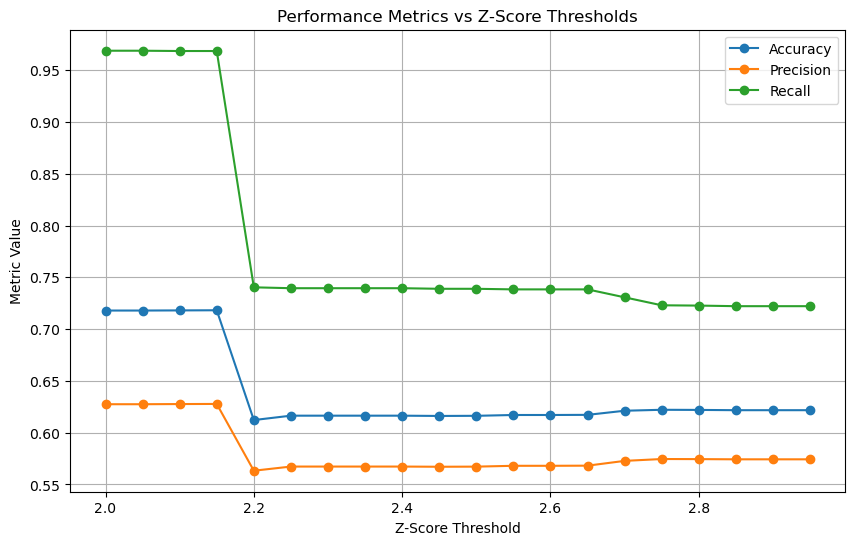

In [54]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
import matplotlib.pyplot as plt

# Task 1

# load the dataset
original = pd.read_csv('Train_data.csv')
data = original

# identify the target column and separate features
class_col = 'class'
X = data.drop(columns=[class_col])
y = data[class_col]

# split data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# separate numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# preprocess numeric data (scale to compute Z-scores)
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_numeric = scaler.transform(X_test[numeric_cols])

# preprocess categorical data (one-hot encoding)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_categorical = encoder.fit_transform(X_train[categorical_cols])
X_test_categorical = encoder.transform(X_test[categorical_cols])

# combine processed numeric and categorical data
X_train_processed = np.hstack((X_train_numeric, X_train_categorical))
X_test_processed = np.hstack((X_test_numeric, X_test_categorical))

# convert the processed data into DataFrame for Z-score computation
X_train_processed_df = pd.DataFrame(X_train_processed)
X_test_processed_df = pd.DataFrame(X_test_processed)

# compute Z-scores
z_scores = np.abs((X_train_processed_df - X_train_processed_df.mean()) / X_train_processed_df.std())

# experiment with different thresholds
thresholds = np.arange(start= 2, stop= 3, step= .05)
results = []

for threshold in thresholds:
    print(f"\nThreshold: {threshold}")

    # predict anomalies for test data
    z_test = np.abs((X_test_processed_df - X_train_processed_df.mean()) / X_train_processed_df.std())
    anomaly_preds = (z_test > threshold).any(axis=1).astype(int)
    # convert y_test to binary (assuming 'normal' = 0, 'anomaly' = 1)
    y_test_binary = (y_test == 'anomaly').astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test_binary, anomaly_preds)
    precision = precision_score(y_test_binary, anomaly_preds)
    recall = recall_score(y_test_binary, anomaly_preds)

    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
    anomalies_detected = anomaly_preds.sum()
    print(f"Anomalies Detected: {anomalies_detected}")
    results.append((threshold, accuracy, precision, recall))

# plot performance metrics for different thresholds
thresholds, accuracies, precisions, recalls = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.xlabel('Z-Score Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs Z-Score Thresholds')
plt.legend()
plt.grid()
plt.show()

In [55]:
# Task 2

original_data = pd.read_csv("Train_data.csv")
train_data = pd.read_csv("Train_data.csv")

# bring the 'class' column back from original data
train_data['class'] = original_data.loc[train_data.index, 'class']

# convert 'class' column to binary values
train_data['class'] = train_data['class'].map({'anomaly': 1, 'normal': 0})

# exclude columns with zero variance
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if train_data[col].std() > 0]

# replace NaN/Inf values
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()

# fit a variety of distributions and calculate MSE
def fit_pdf_and_calculate_mse(data):
    distributions = [stats.norm, stats.expon, stats.uniform, stats.pareto, stats.gamma,
                     stats.weibull_min]
    best_fit = None
    min_mse = float('inf')
    best_params = None
    best_dist = None

    for dist in distributions:
        try:
            # fit the distribution to the data
            params = dist.fit(data)
            # generate a range of values based on the data range
            x_range = np.linspace(min(data), max(data), len(data))
            # calculate the PDF for this distribution
            pdf = dist.pdf(x_range, *params)
            # compare the empirical distribution with the fitted PDF using MSE
            mse = mean_squared_error(data, pdf)

            # track the best-fit distribution
            if mse < min_mse:
                min_mse = mse
                best_fit = pdf
                best_params = params
                best_dist = dist

        except Exception as e:
            # handle cases where fitting fails for a distribution
            print(f"Fitting failed for {dist.name} with error: {e}")

    return best_fit, best_dist, best_params, min_mse


for column in numerical_columns:
    # skip column if it contains NaN values
    data = train_data[column]

    # ensure data is numeric
    if not pd.api.types.is_numeric_dtype(data):
        print(f"Skipping column {column} because it is not numeric.")
        continue

    # remove NaN or infinite values (if any)
    clean_data = data.dropna()  # Drop NaN values
    clean_data = clean_data[np.isfinite(clean_data)]  # Drop infinite values

    if clean_data.empty:
        print(f"Skipping column {column} due to lack of valid data.")
        continue

    # handle extreme values by clipping or removing outliers
    # clipping values to a reasonable range (adjust as needed)
    clip_min, clip_max = clean_data.quantile(0.01), clean_data.quantile(0.99)  # 1st and 99th percentiles
    clean_data = clean_data.clip(lower=clip_min, upper=clip_max)

    # skip column if it has constant or zero variance
    if clean_data.nunique() <= 1 or clean_data.std() == 0:
        print(f"Skipping column {column} due to insufficient variance or constant values.")
        continue

    try:
        best_fit, best_dist, best_params, min_mse = fit_pdf_and_calculate_mse(clean_data)
        if best_dist is not None:
            print(f"Best Distribution: {best_dist.name}")
            print(f"Parameters: {best_params}")
            print(f"Mean Squared Error: {min_mse}")
        else:
            print(f"Skipping column {column} as no valid distribution was found.")
    except Exception as e:
        print(f"Fitting failed for {column} with error: {e}")
    print(f"")

Best Distribution: expon
Parameters: (0.0, 164.96005398539234)
Mean Squared Error: 1372375.0948660253

Best Distribution: uniform
Parameters: (0.0, 54540.0)
Mean Squared Error: 39182577.43811473

Best Distribution: uniform
Parameters: (0.0, 25949.170000000002)
Mean Squared Error: 17009484.227116123

Skipping column land due to insufficient variance or constant values.
Skipping column wrong_fragment due to insufficient variance or constant values.
Skipping column urgent due to insufficient variance or constant values.
Best Distribution: uniform
Parameters: (0.0, 2.0)
Mean Squared Error: 0.2850905049221975

Skipping column num_failed_logins due to insufficient variance or constant values.
Best Distribution: norm
Parameters: (0.3947681803747221, 0.48880084302131993)
Mean Squared Error: 0.33683019578039664

Best Distribution: uniform
Parameters: (0.0, 1.0)
Mean Squared Error: 0.9892029215624007

Skipping column root_shell due to insufficient variance or constant values.
Skipping column su_

In [59]:
# A function that calculates the pmf
def calculate_pmf(data):
    value_counts = data.value_counts(normalize=True)
    total_count = len(data)
    pmf = value_counts / total_count
    return pmf

# Dictionary to store the PMFs for all categorical columns
pmf_results = {}

# calculate PMF for each categorical column
categorical_columns = train_data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"calculating PMF for column: {column}")

    # calculate the overall PMF for the column
    pmf_results[column] = {}
    pmf_results[column]['overall_pmf'] = calculate_pmf(train_data[column])

    # calculate the conditional PMF for anomaly (class == 1)
    anomaly_data = train_data[train_data['class'] == 1]
    pmf_results[column]['anomaly_pmf'] = calculate_pmf(anomaly_data[column])

    # calculate the conditional PMF for normal (class == 0)
    normal_data = train_data[train_data['class'] == 0]
    pmf_results[column]['normal_pmf'] = calculate_pmf(normal_data[column])


calculating PMF for column: protocol_type
calculating PMF for column: service
calculating PMF for column: flag


In [57]:
# print PMF results for reference
for column, pmf_data in pmf_results.items():
    print(f"\nPMF for column: {column}")
    print("Overall PMF:")
    print(pmf_data['overall_pmf'])
    print("Conditional PMF for Anomalies (class=1):")
    print(pmf_data['anomaly_pmf'])
    print("Conditional PMF for Normal (class=0):")
    print(pmf_data['normal_pmf'])


PMF for column: protocol_type
Overall PMF:
protocol_type
tcp     0.000032
udp     0.000005
icmp    0.000003
Name: proportion, dtype: float64
Conditional PMF for Anomalies (class=1):
protocol_type
tcp     0.000071
icmp    0.000010
udp     0.000004
Name: proportion, dtype: float64
Conditional PMF for Normal (class=0):
protocol_type
tcp     0.000059
udp     0.000014
icmp    0.000001
Name: proportion, dtype: float64

PMF for column: service
Overall PMF:
service
http         1.261036e-05
private      6.855889e-06
domain_u     2.867782e-06
smtp         2.283195e-06
ftp_data     2.199683e-06
                 ...     
urh_i        6.302817e-09
red_i        4.727113e-09
pm_dump      4.727113e-09
tim_i        3.151408e-09
http_8001    1.575704e-09
Name: proportion, Length: 66, dtype: float64
Conditional PMF for Anomalies (class=1):
service
private      3.010920e-05
eco_i        5.917415e-06
ecr_i        4.169747e-06
http         3.183511e-06
ftp_data     2.864435e-06
                 ...     
X